# PRISMO vs MEFISTO on Mouse brain Visium data

## MEFISTO

In [63]:
# from mofapy2.run.entry_point import entry_point
# from data_loader import load_mefisto_visium

# adata = load_mefisto_visium()

# ent = entry_point()
# ent.set_data_options(use_float32=True)
# ent.set_data_from_anndata(adata)
# ent.set_model_options(factors=4)
# ent.set_train_options()
# ent.set_train_options(seed=54321)
# n_inducing = 1000

# ent.set_covariates([adata.obsm["spatial"]], covariates_names=["imagerow", "imagecol"])
# ent.set_smooth_options(sparseGP=True, frac_inducing=n_inducing / adata.n_obs, start_opt=10, opt_freq=10)
# ent.build()
# ent.run()

# expectations = ent.model.getExpectations()
# ent.save("models/mefisto.hdf5")

## PRISMO

In [64]:
# from data_loader import load_mefisto_visium
# from prismo import PRISMO, DataOptions, ModelOptions, TrainingOptions, SmoothOptions

# adata = load_mefisto_visium()

# for seed in range(10):
#     prismo_model = PRISMO(
#         adata,
#         DataOptions(
#             covariates_obsm_key="spatial",
#             plot_data_overview=False
#         ),
#         ModelOptions(
#             n_factors=4,
#             weight_prior="Horseshoe",
#             factor_prior="GP",
#             likelihoods="Normal"
#         ),
#         TrainingOptions(
#             device="cuda:0",
#             early_stopper_patience=500,
#             lr=5e-2,
#             save_path=f"models_hs/prismo_{seed}",
#             seed=seed
#         ),
#         SmoothOptions(
#             n_inducing=1000,
#             kernel="RBF"
#         )
#     )

## Comparison

In [65]:
%load_ext autoreload
%autoreload 2

import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

import plotting_settings
from functools import partial
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import mofax as mofa
from prismo import PRISMO
from prismo.tl import match
from plotnine import *
from data_loader import load_mefisto_visium
import os
import h5py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
view_names = {
    "rna" : "mRNA"
}

In [67]:
mefisto_model = mofa.mofa_model("mefisto.hdf5")
z_mefisto = pd.DataFrame(
    mefisto_model.factors["group1"][:].T,
    index=mefisto_model.samples["group1"],
    columns=[f"Factor {i+1}" for i in range(mefisto_model.nfactors)],
) / 10

w_mefisto = {}
for view in mefisto_model.views:
    w_mefisto[view_names[view.item()]] = pd.DataFrame(
        mefisto_model.weights[view][:].T,
        index=mefisto_model.features["rna"],
        columns=[f"Factor {i+1}" for i in range(mefisto_model.nfactors)]
    ) * 10

In [68]:
z_prismo = {}
w_prismo = {}
prismo_model = {}
for seed in range(10):
    prismo_model[seed] = PRISMO.load(f"models_sns/prismo_{seed}.h5")
    z_prismo[seed] = prismo_model[seed].get_factors()['group_1']
    w_prismo[seed] = {}
    for view in view_names.keys():
        w_prismo[seed][view_names[view]] = prismo_model[seed].get_weights()["view_1"].T

### Factor matching based on correlation

In [69]:
for seed in range(10):
    z_mefisto_inds, z_prismo_inds, z_signs = match(z_mefisto, z_prismo[seed], dim=-1)

    z_prismo[seed] = z_prismo[seed].iloc[:, z_prismo_inds]
    z_prismo[seed] = z_prismo[seed] * z_signs.reshape(1, -1)
    z_prismo[seed].columns = [f"Factor {i+1}" for i in range(z_prismo[seed].shape[1])]

    for view in w_prismo[seed].keys():
        w_prismo[seed][view] = w_prismo[seed][view].iloc[:, z_prismo_inds]
        w_prismo[seed][view] = w_prismo[seed][view] * z_signs.reshape(1, -1)
        w_prismo[seed][view].columns = [f"Factor {i+1}" for i in range(w_prismo[seed][view].shape[1])]

### Correlation plots

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 2.4 x 2 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/correlations.pdf
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 1 rows containing missing values.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 1 rows conta

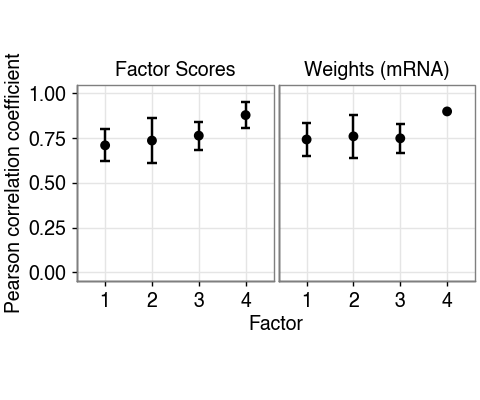

In [70]:
df = []
for seed in range(10):
    corr = []
    for i in range(z_prismo[seed].shape[1]):
        corr.append(pearsonr(z_prismo[seed].iloc[:, i], z_mefisto.iloc[:, i])[0])
    df.append(pd.DataFrame(corr, columns=["corr"]))
    df[-1]["seed"] = seed
    df[-1]["factor"] = [f"{i+1}" for i in range(z_prismo[seed].shape[1])]
    df[-1]["lv"] = "Factor Scores"

    for view in w_prismo[seed].keys():
        corr = []
        for i in range(w_prismo[seed][view].shape[1]):
            corr.append(pearsonr(w_prismo[seed][view].iloc[:, i], w_mefisto[view].iloc[:, i])[0])
        df.append(pd.DataFrame(corr, columns=[f"corr"]))
        df[-1]["seed"] = seed
        df[-1]["factor"] = [f"{i+1}" for i in range(w_prismo[seed][view].shape[1])]
        df[-1]["lv"] = f"Weights ({view})"

df = pd.concat(df, axis=0)

df = df.groupby(["factor", "lv"])["corr"].aggregate(["mean", "std"]).reset_index()
df["min"] = df["mean"] - df["std"]
df["max"] = df["mean"] + df["std"]
df["factor"] = pd.Categorical(df["factor"], categories=[f"{i+1}" for i in range(10)], ordered=True)
df["min"] = np.clip(df["min"], a_min=0, a_max=10)
df["max"] = np.clip(df["max"], a_min=0, a_max=10)

plot = (
    ggplot(df, aes(x="factor", y="mean"))
    + geom_point(size=1.)
    + geom_line()
    + geom_errorbar(aes(ymin="min", ymax="max"), width=0.2)
    + facet_wrap("~lv", scales="fixed", ncol=5)
    + theme(
        figure_size=(2.4, 2),
    )
    + labs(x="Factor", y="Pearson correlation coefficient")
    + ylim(0., 1.)
)
plot.save("plots/correlations.pdf")
plot.show()

### Weights scatter plots

In [71]:
def plot_weights(view, factor, w_prismo, w_mefisto):
    df = pd.DataFrame(w_prismo[view][factor])
    df.columns = ["weight_prismo"]
    df["weight_mefisto"] = w_mefisto[view][factor]
    df["weight_prismo_abs"] = df["weight_prismo"].abs()
    df["weight_mefisto_abs"] = df["weight_mefisto"].abs()

    plot = (
        ggplot(df, aes(x="weight_prismo", y="weight_mefisto"))
        + geom_point(size=.1)
        + labs(x="PRISMO", y="MEFISTO", title=f"Weights {factor}")
        + theme(figure_size=(1.5, 1.5), plot_title=element_text(ha='left'))
        + geom_hline(yintercept=0, linetype='dashed', color='black', alpha=0.3)
        + geom_vline(xintercept=0, linetype='dashed', color='black', alpha=0.3)
    )
    return plot

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor1_weights.pdf


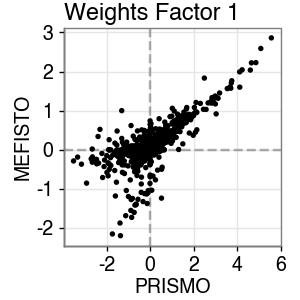

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor2_weights.pdf


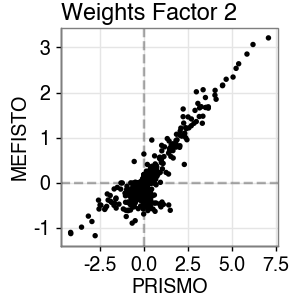

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor3_weights.pdf


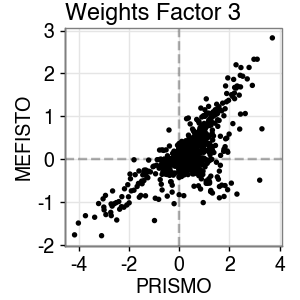

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor4_weights.pdf


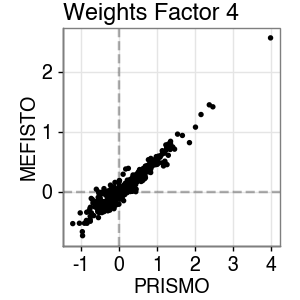

In [72]:
for i in range(1, 5):
    plot = plot_weights("mRNA", f"Factor {i}", w_prismo[1], w_mefisto)
    plot.save(f"plots/factor{i}_weights.pdf")
    plot.show()

### Factor scatter plots

In [73]:
def plot_factors(factor, z_prismo, z_mefisto):
    df = pd.DataFrame(z_prismo.loc[:, factor])
    df.columns = ["factor_prismo"]
    df["factor_mefisto"] = z_mefisto.loc[:, factor]
    df["factor_prismo_abs"] = df["factor_prismo"].abs()
    df["factor_mefisto_abs"] = df["factor_mefisto"].abs()

    plot = (
        ggplot(df, aes(x="factor_prismo", y="factor_mefisto"))
        + geom_point(size=.01)
        + labs(x="PRISMO", y="MEFISTO", title=f"Factor Scores {factor}")
        + theme(figure_size=(1.5, 1.5))
        + geom_hline(yintercept=0, linetype='dashed', color='black', alpha=0.3)
        + geom_vline(xintercept=0, linetype='dashed', color='black', alpha=0.3)
    )
    return plot

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor1_factors.pdf


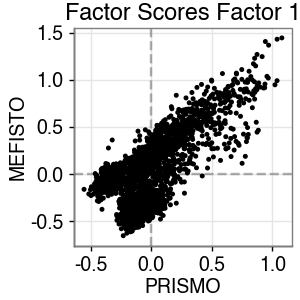

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor2_factors.pdf


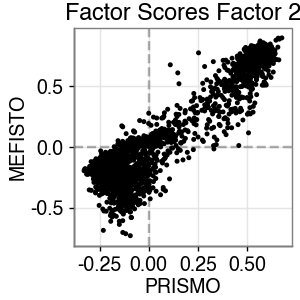

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor3_factors.pdf


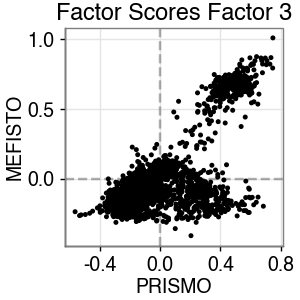

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor4_factors.pdf


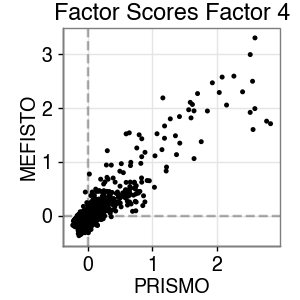

In [74]:
for i in range(1, 5):
    plot = plot_factors(f"Factor {i}", z_prismo[1], z_mefisto)
    plot.save(f"plots/factor{i}_factors.pdf")
    plot.show()

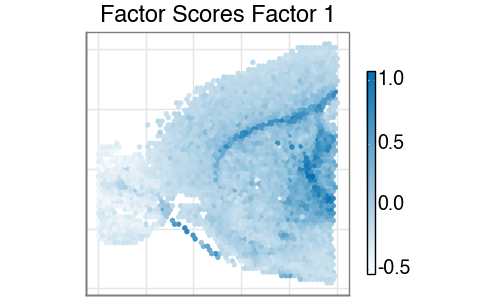

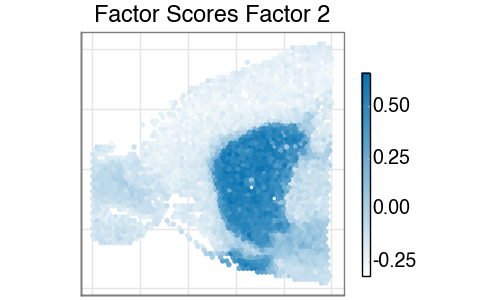

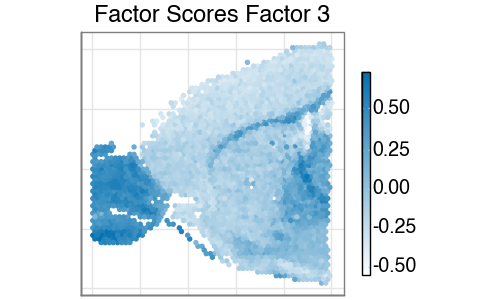

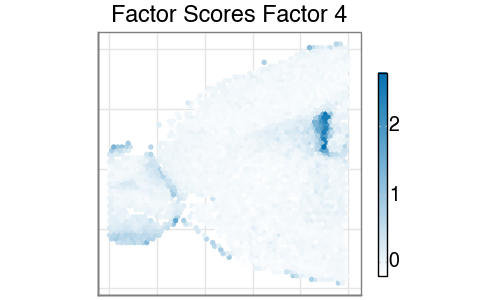

In [77]:
covariates_df = pd.DataFrame(prismo_model[1].covariates["group_1"], columns=["x", "y"])
factors_df = pd.DataFrame(z_prismo[1], columns=[f"Factor {i+1}" for i in range(z_prismo[1].shape[1])])
covariates_df.index = factors_df.index
df = pd.concat([covariates_df, factors_df], axis=1)
df["y"] = -df["y"]

for factor in range(1, 5):
    plot = (ggplot(df, aes(x="x", y="y", color=f"Factor {factor}"))
        + geom_point(size=0.1)
        + theme(figure_size=(2.5, 1.5), axis_text_x=element_blank(), axis_text_y=element_blank(), axis_ticks_major_x=element_blank(), axis_ticks_major_y=element_blank(), legend_key_width=3.)
        + labs(x="", y="", color="", title=f"Factor Scores Factor {factor}")
        + coord_fixed(ratio=1)
        + scale_color_gradient(low="white", high="#0571b0")
    )

    fig = plot.draw()
    points = fig.axes[0].collections[0]
    points.set_rasterized(True)
    fig.savefig(f"plots/prismo_factor_{factor}.pdf")
    plot.show()

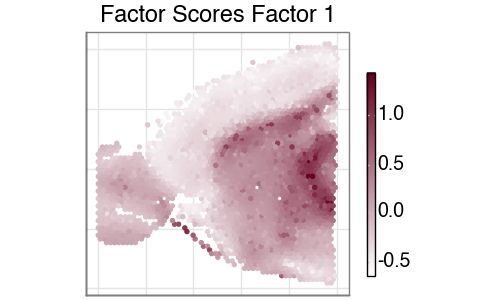

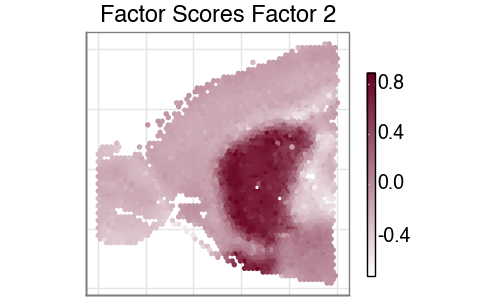

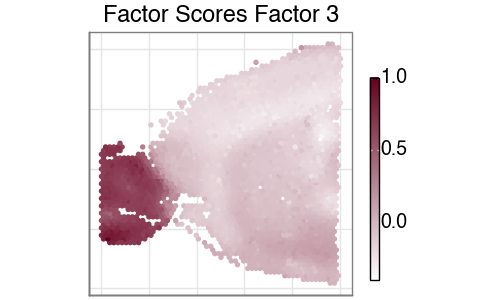

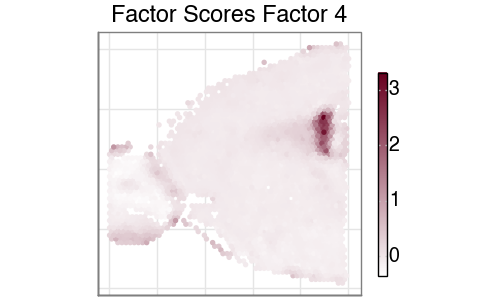

In [78]:
covariates_df = pd.DataFrame(prismo_model[0].covariates["group_1"], columns=["x", "y"])
factors_df = pd.DataFrame(z_mefisto, columns=[f"Factor {i+1}" for i in range(z_prismo[1].shape[1])])
covariates_df.index = factors_df.index
df = pd.concat([covariates_df, factors_df], axis=1)
df["y"] = -df["y"]

for factor in range(1, 5):
    plot = (ggplot(df, aes(x="x", y="y", color=f"Factor {factor}"))
        + geom_point(size=0.1)
        + theme(figure_size=(2.5, 1.5), axis_text_x=element_blank(), axis_text_y=element_blank(), axis_ticks_major_x=element_blank(), axis_ticks_major_y=element_blank(), legend_key_width=3.)
        + labs(x="", y="", color="", title=f"Factor Scores Factor {factor}")
        + coord_fixed(ratio=1)
        + scale_color_gradient(low="white", high="#67001f")
    )

    fig = plot.draw()
    points = fig.axes[0].collections[0]
    points.set_rasterized(True)
    fig.savefig(f"plots/mefisto_factor_{factor}.pdf")
    plot.show()